<a href="https://colab.research.google.com/github/Swicano/IntroML_NBs/blob/master/ObjectNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing my own neural network framework, without using global variables. though perhaps using a class?

In [0]:
from numpy import *
import time
import copy
import matplotlib.pyplot as plt # for plotting
%matplotlib inline


In [0]:
class SimpleNN:
  
  # here we init the class variables and set up the structure, as well 
  #    the nonlinear and Cost function if ones are passed
  #    neur is a list of ints, where each int is the number of neurons in a layer
  #    and the position in the list is that layer number
  def __init__(self, neur , f=None, C=None ):
    self.neurons = neur
    self.layers = len(neur)
    
    # the default nonlinear function is a sigmoid
    if f is None:
      def f(x):
        val=1/(1+exp(-x))
        return(val,exp(-x)*(val**2))
      self.nonlin = f
    else:
      self.nonlin = f
    
    # the default cost function is norm^2
    if C is None:
      def C(yout,ytarget):
        diff = 1/(2*shape(yout)[0])*((yout-ytarget)**2)
        ddiff = 1/(shape(yout)[0])*(yout-ytarget)
        return(diff,ddiff)
      self.fcost = C
    else:
      self.fcost = C
        
    self.y_n = []
    self.dy_n = []
    self.z_n = []
    self.biases = []
    self.dbiases = []
    for i in range(0,self.layers):
      b = random.uniform(low=-5,high=+5,size=(1,self.neurons[i]))
      db = random.uniform(low=-5,high=+5,size=(1,self.neurons[i]))
      self.biases.append(b)
      self.dbiases.append(db)
      self.y_n.append(zeros(self.neurons[i]))
      self.dy_n.append(zeros(self.neurons[i]))
      self.z_n.append(zeros(self.neurons[i]))
      
    self.weights=[]
    for i in range(0,self.layers-1):
      w = random.uniform(low=-5,high=+5,size=(self.neurons[i],self.neurons[i+1]))
      dw = random.uniform(low=-5,high=+5,size=(self.neurons[i],self.neurons[i+1]))
      self.weights.append([w,dw])
         
    #here we try it with biases built into the weights vector (this is semi failed)
    self.yb_n = []
    self.dyb_n = []
    self.zb_n = []
    for i in range(0,self.layers):
      y  = zeros(self.neurons[i])
      dy = zeros(self.neurons[i])
      self.yb_n.append(y)
      self.dyb_n.append(dy)
      self.zb_n.append(zeros(self.neurons[i]))
    
    self.weightsb=[]
    for i in range(0,self.layers-1):
      wb = random.uniform(low=-1,high=+1,size=(self.neurons[i]+1,self.neurons[i+1]))
      dwb = random.uniform(low=-1,high=+1,size=(self.neurons[i]+1,self.neurons[i+1]))
      self.weightsb.append([wb,dwb])
    # end init------------------------------------------------------------#
  
  #if you want the current cost separately
  def Cost(self,yout,ytarget):
      self.cost = self.fcost(yout,ytarget)[0].sum()
      return (self.cost)
   
  def Apply_net(self,yin):
    self.y_n[0] = yin
    self.dy_n[0] = yin
    for i in range(0,self.layers-1):
      self.z_n[i+1] = dot(self.y_n[i],self.weights[i][0])+self.biases[i+1][0]
      y,dy = self.nonlin(self.z_n[i+1])
      self.y_n[i+1] = y
      self.dy_n[i+1] = dy
    return (self.y_n[-1]) 
  
  # combined Weights-Biases version of the above
  def Apply_net_wb(self,yin):
    batchsize = len(yin)
    self.yb_n[0] = yin
    self.dyb_n[0] = yin
    for i in range(0,self.layers-1):
      y  = append(self.yb_n[i],ones((batchsize,1)),axis=1)
      dy = append(self.dyb_n[i],ones((batchsize,1)),axis=1)
      self.yb_n[i] = y
      self.dyb_n[i] = dy
      
      self.zb_n[i+1] = dot(self.yb_n[i],self.weightsb[i][0])
      y,dy = self.nonlin(self.zb_n[i+1])
      self.yb_n[i+1] = y
      self.dyb_n[i+1] = dy
    return (self.yb_n[-1])
   
  def Backprop(self, yin, ytarget): 
    self.Apply_net(yin)
    self.Cost(self.y_n[-1],ytarget)
    # delta is an element-wise multiplication of two [batchsize x len(y_out)] vectors
    # the first is the value of the derivative of the (cost) function w.r.t. (yout)
    # the second is the value of the derivative of (yout) w.r.t. (zout)
    delta = self.fcost(self.y_n[-1],ytarget)[1]*self.dy_n[-1]
    # dw at the top layer is then the dot product of 
    #   delta and the derivative of (zout) w.r.t the weights matrix, aka, y^(n-1)
    #   but we do this by arranging the dot product over the batch vector to 
    #     take care of the sum at the same time
    dw = dot(transpose(self.y_n[-(2)]), delta)
    db = delta.sum(0)
    self.weights[-1][1] = dw
    self.dbiases[-1] = db
    # for all below layers we use this form
    for i in range(1,self.layers-1):
      delta = dot(delta,transpose(self.weights[-i][0]))*self.dy_n[-(i+1)]
      dw = dot(transpose(self.y_n[-(i+2)]), delta)
      db = delta.sum(0)
      self.weights[-(i+1)][1] = dw
      self.dbiases[-(i+1)] = db
    return (self.cost)  
  
  # combined Weights-Biases version of the above
  def Backprop_wb(self, yin, ytarget):
    self.Apply_net_wb(yin)
    self.Cost(self.yb_n[-1],ytarget)
    # delta is an element-wise multiplication of two [batchsize x len(y_out)] vectors
    # the first is the value of the derivative of the (cost) function w.r.t. (yout)
    # the second is the value of the derivative of (yout) w.r.t. (zout)
    delta = self.fcost(self.yb_n[-1],ytarget)[1]*self.dyb_n[-1]
    # dw at the top layer is then the dot product of 
    #   delta and the derivative of (zout) w.r.t the weights matrix, aka, y^(n-1)
    #   but we do this by arranging the dot product over the batch vector to 
    #     take care of the sum at the same time
    dw = dot(transpose(self.yb_n[-(2)][:,:]), delta)
    self.weightsb[-1][1] = dw
    # for all below layers we use this form
    for i in range(1,self.layers-1):
      delta = dot(delta,transpose(self.weightsb[-i][0])[:,:-1])*self.dyb_n[-(i+1)][:,:-1]
      dw = dot(transpose(self.yb_n[-(i+2)]), delta)
      self.weightsb[-(i+1)][1] = dw
    return (self.cost)
  
  #the gradient step has the added option to have eta vary randomly by the factor 'rand'
  def Gradient_step(self,step,rand): 
    eta = step #*(1+random.uniform(-rand,rand))
    for i in range(0,self.layers-1):
      self.weights[i][0]-=eta*self.weights[i][1]
      self.biases[i]-=eta*self.dbiases[i]
  # combined Weights-Biases version of the above
  def Gradient_step_wb(self,step,rand):
    eta = step*(1+random.uniform(-rand,rand))
    for i in range(0,self.layers-1):
      self.weightsb[i][0]-=eta*self.weightsb[i][1]
      

  
  


In [0]:
# this Cell generates a uniform input batch that covers -0.5 to +0.5 in both inputs
# and makes the output easily graphed
import matplotlib.pyplot as plt # for plotting
%matplotlib inline

M=200
# Generate a 'mesh grid', i.e. x,y values in an image
v0,v1=meshgrid(linspace(-0.5,0.5,M),linspace(-0.5,0.5,M))
v0flat=v0.flatten() # make 1D array out of 2D array
v1flat=v1.flatten() # that means: MxM matrix becomes M^2 vector

batchsize=shape(v0flat)[0] # number of samples = number of pixels
y_in=zeros([batchsize,2])
y_in[:,0]=v0flat # fill first component (index 0)
y_in[:,1]=v1flat # fill second component


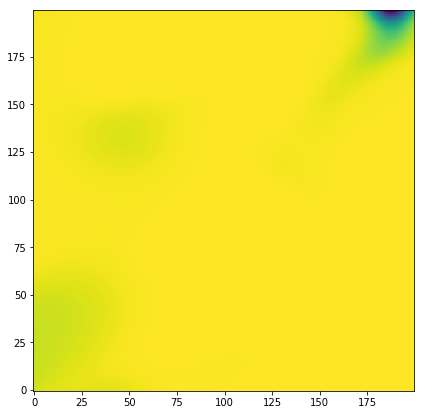

In [0]:
# we can define any nonlinear function other than the default sigmoid
#   Simply define it as below, so that it takes one input, and returns
#   the output f(x) as well as the derivative f'(x)
def ReLU(x):
  val = x*(x>0)
  return (val, 1*(x>0))

# the same goes for Cost functions which takes 2 inputs
#   the output vector y_out calculated from y_in, and
#      and also the desired output vector y_target
#   Output the same as above, where we return C(yin,yout), and dC(yin, yout)/df
def Cost(x,y):
  return (1,1)

# here we define the nn with:
#   2 input neurons, 100 neurons in a hidden layer, and 1 ouput
#   as well, we use ReLU instead of sigmoid as our nonlinear
#   and by not defining a cost function we use the default
simples = SimpleNN([2,50,100,50,1])#,f=ReLU)


# all weights are initialized randomly, but we run the graphing input from above
# and see that we get an output that probably means nothing
y_out = simples.Apply_net(y_in)   # we use the normal net to get a yout
y_out1 = simples.Apply_net_wb(y_in)
y_2D=reshape(y_out[:,0],[M,M])    # reformat yout to graph
plt.figure(figsize=[7,7])
plt.imshow(y_2D,origin='lower')   # aaand plot it
plt.show()

In [0]:
# Here we begin attempting to train that random net above
#   by first defining a function which will be our target 
def myFunc(yin):
  r2=(yin**2).sum(1)
  return(exp(-5*r2)*abs(yin.sum(1)))

def myFunc2(yin):
  x = sin(10*yin[:,0])
  y = cos(12*yin[:,1])
  return((x*y+1)/2)

#then we create a training batch by randomly sampling a function
# this function was not generalized properly, it only works on 1d outputs
def make_batch(batchsize, insize, outsize, func=myFunc):
  inputs=random.uniform(low=-0.5,high=+0.5,size=[batchsize,insize])
  targets=zeros([batchsize,outsize]) # must have right dimensions
  targets[:,0]=func(inputs)
  return(inputs,targets)

yint,yintest = make_batch(100,2,1)


In [0]:
import copy
backup12 = copy.deepcopy(simples)



In [0]:
# a deepcopy lets us reinitialize the nn to its' untrained state easily, 
#   even with random weights
simples = copy.deepcopy(backup12)  #CHANGE
costs12 = []                       #CHANGE
times12 = []                       #CHANGE

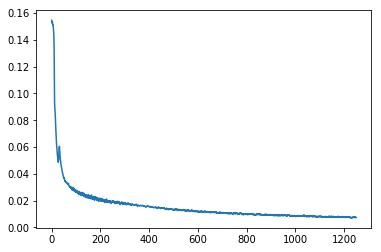

In [0]:
#here we do the actual training
training_size = 500 #number of dC/dw steps
training_time = 1000 # train for this many seconds
batch_size = 20
start = time.time()
end = time.time()+training_time

#for i in range(training_size):  #if you want to train a set number of iterations
while (time.time() < end):       # if you just want to train for a set amount of time
  yint, yintest = make_batch(batchsize, 2,1, func=myFunc2)
  costs12.append(simples.Backprop(yint, yintest))             # CHANGE
  simples.Gradient_step(1.001,0.001)
  time_curr = time.time()
  times12.append(time_curr-start)                             # CHANGE
  start=time_curr
  
#print(costs1)
plt.plot(costs12)                                             # CHANGE
#plt.plot(times1)

In [0]:
times12tot = []                                   # Change
times12tot.append(times12[0])                     # Change CHANGE
for i in range(1,len(times12)):                   # Change
  times12tot.append(times12tot[-1]+times12[i])    # CHANGE CHANGE CHANGE
  
print(times12tot[-1])                             # CHANGE

1000.517697095871


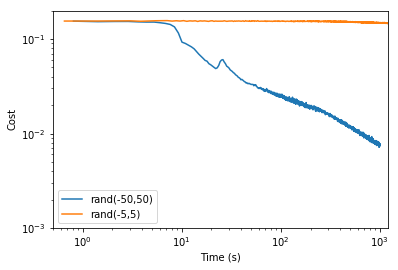

In [58]:
#plt.plot(times9tot,costs9, 'g')
plt.plot(times12tot,costs12)
#plt.plot(times8tot,costs8, 'r')
#plt.plot(times7tot,costs7, 'b')     #CHANGE    CHANGE
plt.plot(times11tot,costs11)
plt.ylabel('Cost')
plt.xlabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.axis([0.5, 1200, 0.001, 0.2])
plt.gca().legend(('rand(-50,50)','rand(-5,5)'),loc='lower left')
plt.show()

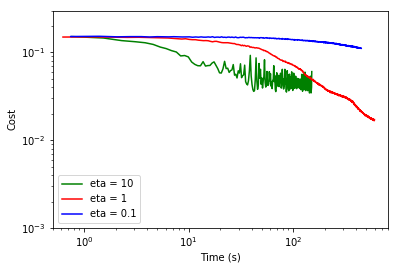

In [0]:
plt.plot(times3tot,costs3, 'g')
plt.plot(times4tot,costs4, 'r')
plt.plot(times5tot,costs5, 'b')     #CHANGE    CHANGE
plt.ylabel('Cost')
plt.xlabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.axis([0.5, 800, 0.001, 0.3])
plt.gca().legend(('eta = 10','eta = 1','eta = 0.1'),loc='lower left')
plt.show()

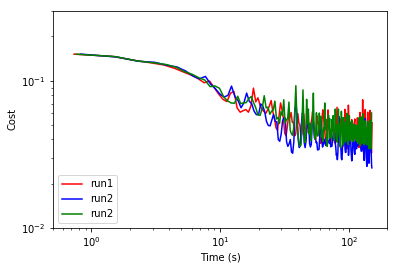

In [0]:
plt.plot(times1tot,costs1, 'r')
plt.plot(times2tot,costs2, 'b')
plt.plot(times3tot,costs3, 'g')
#plt.plot(times4tot,costs4, 'g')     #CHANGE    CHANGE
plt.ylabel('Cost')
plt.xlabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.axis([0.5, 200, 0.01, 0.3])
plt.gca().legend(('run1','run2','run2'),loc='lower left')
plt.show()

(40000,)


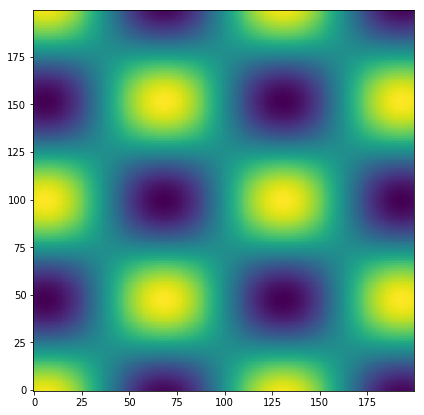

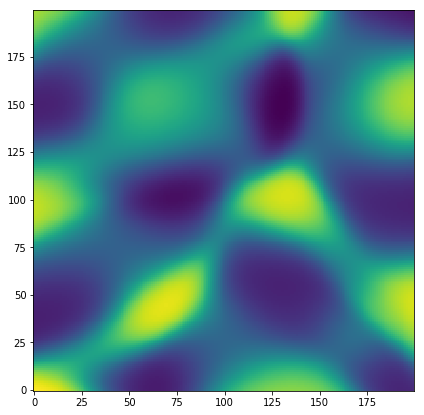

In [0]:
#finally we plot the training function and the neural net output to compare
y_out_corr = myFunc2(y_in)
print(shape(y_out_corr))
y_2Dc=reshape(y_out_corr[:],[M,M])
plt.figure(figsize=[7,7])
plt.imshow(y_2Dc,origin='lower')
plt.show()

y_out1 = simples.Apply_net(y_in)
y_2Dn=reshape(y_out1[:,0],[M,M])
plt.figure(figsize=[7,7])
plt.imshow(y_2Dn,origin='lower')
plt.show()

In [0]:
import time
time.time()
time.clock()


2.366227